In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mpld3
from datetime import datetime, timedelta

pd.set_option('chained_assignment', None)
plt.style.use('seaborn-darkgrid')
mpld3.enable_notebook()
%matplotlib inline

### Parameters

In [2]:
# For intra-day trading, we only will work with one date at a time
date = datetime(2017, 10, 19)

# Names of files for each Bitcoin data set
data_sets = {
    'coinbase': 'coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv',
    'coincheck': 'coincheckJPY_1-min_data_2014-10-31_to_2017-10-20.csv',
    'bitstamp': 'bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv'
}

data_dir = './data'

### Read in data

In [3]:
def read_data(path):
    next_date = date + timedelta(days=1)
    df = (
        pd
        .read_csv(os.path.join(data_dir, path))
        .assign(Timestamp = lambda x: pd.to_datetime(x.Timestamp, unit='s'))
        .rename(columns={'Volume_(BTC)':'volume', 'Weighted_Price':'price'})
        .loc[lambda x: (x.Timestamp >= date) & (x.Timestamp < next_date), ['Timestamp','price']]
        .sort_values('Timestamp')
        .set_index('Timestamp')
    )
    for c in df.columns:
        df[c] = df[c].astype(float)
    return df

# Merge all three datasets together
df = pd.concat([read_data(x) for x in data_sets.values()], axis=1)
df.columns = ['%s_price' % x for x in data_sets.keys()]

# Split into training/test - use last 6 hours of day for test
train = df.iloc[:-360]
test = df.iloc[-360:]
del df

### Build Model

In [4]:
from model import Normalizer

# Normalize data, create target/feature columns
norm = Normalizer()
norm.fit(train)

input_columns = train.columns.tolist()

train = norm.transform(train)
test = norm.transform(test)

train, train_target, test, test_target = norm.make_target_columns(train, test)

print(train.shape[0])
print(test.shape[0])

1080
359


In [5]:
from model import Model

# WaveNet params
params = {
    'num_time_steps': train.shape[0],
    'num_filters': 1,
    'num_layers': 7,
    'learning_rate': 1e-3,
    'regularization': 1e-2,
    'n_iter': 15000,
    'logdir': '/var/data/tensorboard',
    'fields': input_columns,
    'seed': 0
}

wavenet = Model(**params)

Graph for run RCIPLZ created


In [6]:
# Format model input
features = dict()
targets = dict()
for column in input_columns:
    f = np.array(train[column])
    f = np.reshape(f, (1, -1))
    features[column] = f
    
    f = np.array(train_target[column])
    f = np.reshape(f, (1, -1))
    targets[column] = f

# Run model
with wavenet:
    # Train
    output = wavenet.train(targets, features)

    # Generate
    num_steps = test.shape[0]
    pred = wavenet.generate(num_steps, features)

Losses at step 0: 31.247929, 31.310808, 31.244688
Losses at step 1000: 1.309297, 1.213006, 1.312786
Losses at step 2000: 0.563402, 0.518445, 0.568844
Losses at step 3000: 0.247427, 0.329582, 0.263971
Losses at step 4000: 0.161057, 0.220336, 0.174751
Losses at step 5000: 0.120730, 0.166690, 0.139597
Losses at step 6000: 0.092663, 0.140921, 0.119571
Losses at step 7000: 0.072836, 0.126856, 0.110181
Losses at step 8000: 0.063637, 0.118806, 0.104124
Losses at step 9000: 0.058990, 0.114322, 0.099703
Losses at step 10000: 0.055625, 0.111146, 0.096391
Losses at step 11000: 0.053501, 0.108627, 0.093808
Losses at step 12000: 0.052309, 0.106866, 0.092498
Losses at step 13000: 0.051758, 0.106147, 0.091908
Losses at step 14000: 0.051535, 0.105912, 0.091725
Final loss: 0.051477, 0.105871, 0.091696
Storing model checkpoint /var/data/tensorboard/RCIPLZ/model.ckpt


### Plot training

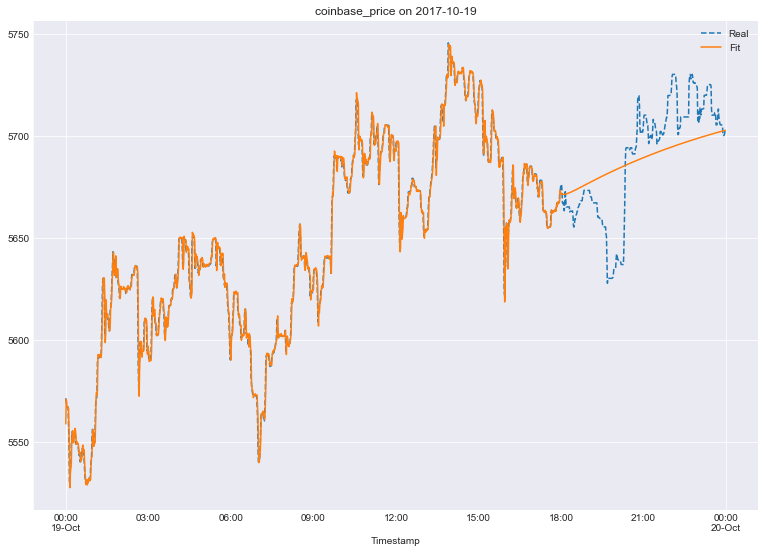

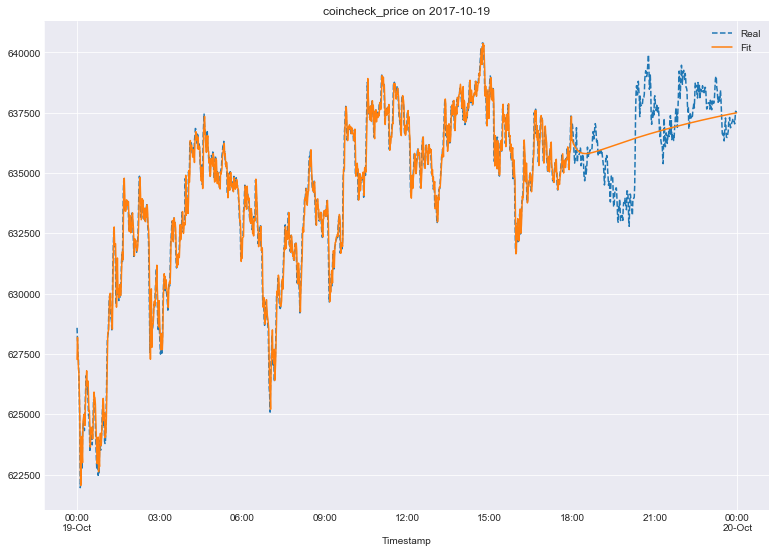

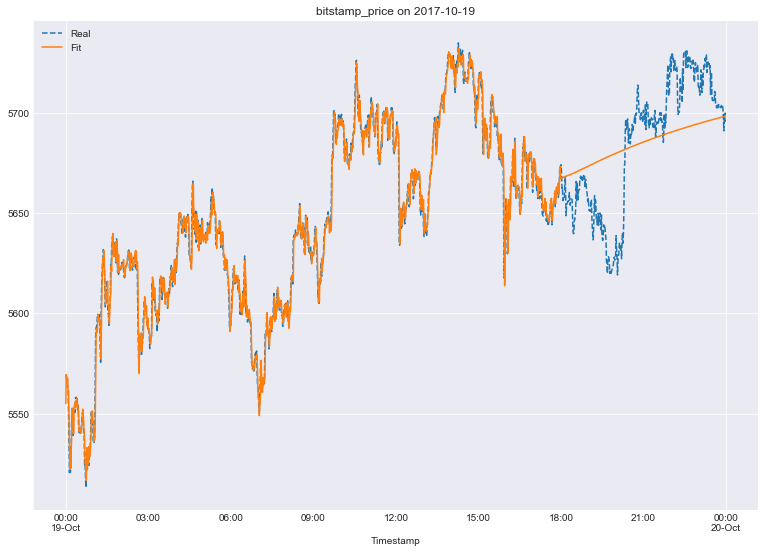

In [7]:
# Merge outputs together
for col in input_columns:
    train_target[col + '_pred'] = np.reshape(output[col], (-1,))
    test_target[col + '_pred'] = np.reshape(pred[col], (-1,))
df = (
    train_target
    .append(test_target)
    .pipe(lambda x: norm.undo_transform(x, suffix='_pred'))
)

for col in input_columns:
    fig = plt.figure(figsize=(13, 9))
    df[col].plot(label='Real', ls='--')
    df[col + '_pred'].plot(label='Fit')
    plt.title(col + " on " + date.strftime("%Y-%m-%d"))
    plt.legend()
    plt.show()